In [1]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2023-05-14 07:49:39--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2023-05-14 07:49:39--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfb8a1fec86516fd73cabd72962.dl.dropboxusercontent.com/cd/0/inline/B8D0pd43qj5x4A4YW_A5O0n0HdCc4m8KVw7jON-UXU_d4MpppJ_-q4fSi5Qo4b_KH-b-zMj7HWmtCPG0pZk51S3u0jznbtqPOlBpEFXRrAuCyXwpJPDv0crhvxXVm1AGsjTacTjwbX03dMVk4VtxhbI2dMAHfFrZt8KjO8Bte3bkCw/file# [following]
--2023-05-14 07:49:39--  https://ucfb8a1fec86516fd73cabd72962.dl.dropboxusercontent.com/cd/0/inline/B8D0pd43qj5x4A4YW_A5O0n0HdCc4m8KVw7jON-UXU_d4MpppJ_-q4fSi5Qo4b_KH-b-zMj7HWmtCPG0pZk

In [2]:
!unzip -q "archive.zip"

replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y, A


In [3]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

tf.random.set_seed(4)

In [4]:
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [5]:
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

print(train_image_paths)

<generator object Path.glob at 0x7f6293366730>


In [6]:
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1010-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0486-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0803-0001.jpeg')]


In [7]:
train_image_paths = list(map(lambda x : str(x), train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths))

print(train_image_paths[:3])


['chest_xray/train/NORMAL/NORMAL2-IM-1010-0001.jpeg', 'chest_xray/train/NORMAL/IM-0486-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0803-0001.jpeg']


In [8]:
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [9]:
LABELS ={'NORMAL' : 0, 'PNEUMONIA': 1}
INV_LABELS = {0: 'NORMAL', 1: 'PNEUMONIA'}

def get_label(path : str) -> int:
  return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x), train_image_paths))
val_labels = list(map(lambda x : get_label(x), val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [10]:
BATCH_SIZE = 32
def get_dataset(paths, labels, train = True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label : load_and_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [11]:

def load_and_transform(image, label, train = True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image,[224,224], method="nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
  return image, label

In [12]:
%time train_dataset = get_dataset(train_image_paths, train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 741 ms, sys: 542 ms, total: 1.28 s
Wall time: 2.01 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


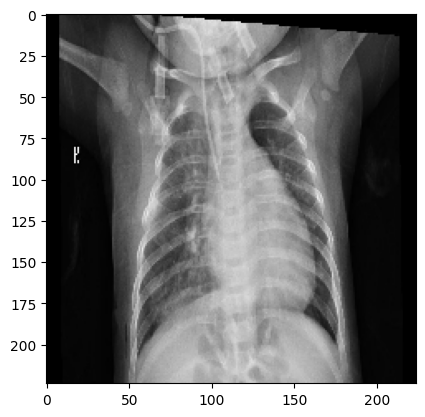

In [13]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [14]:
%time val_dataset = get_dataset(val_image_paths, val_labels, train = False)

image , label=next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 20.1 ms, sys: 3 µs, total: 20.1 ms
Wall time: 23.7 ms
(32, 224, 224, 3)
(32,)


In [21]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model =tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True, save_weights_only= True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [24]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9316 - precision: 0.9462 - recall: 0.9519
Epoch 1: val_loss improved from inf to 106.43740, saving model to best_weights.h5
163/163 [==============================] - 140s 462ms/step - loss: 0.1775 - accuracy: 0.9316 - precision: 0.9462 - recall: 0.9519 - val_loss: 106.4374 - val_accuracy: 0.3701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9657 - precision: 0.9768 - recall: 0.9765
Epoch 2: val_loss improved from 106.43740 to 2.71820, saving model to best_weights.h5
163/163 [==============================] - 66s 406ms/step - loss: 0.0946 - accuracy: 0.9657 - precision: 0.9768 - recall: 0.9765 - val_loss: 2.7182 - val_accuracy: 0.7516 - val_precision: 0.7143 - val_recall: 0.9973
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9693 - precision: 0.9798 - recall: 

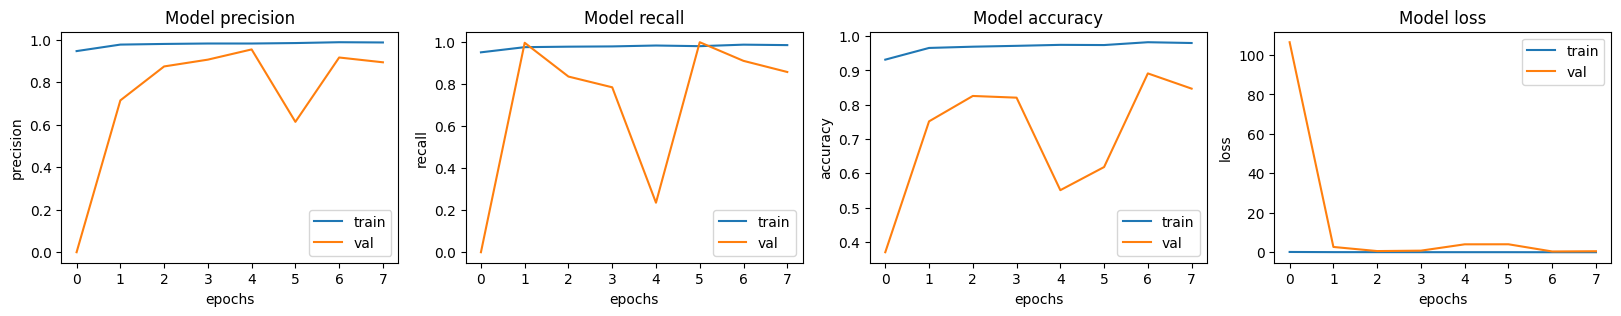

In [25]:
fig, ax = plt.subplots(1,4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_'+met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

In [26]:
model.load_weights("best_weights.h5")
model.save("model.h5")

In [27]:
loaded_model = tf.keras.models.load_model("model.h5")

In [29]:
test_image_paths = list(test_path.glob("*/*"))
test_image_paths=list(map(lambda x : str(x), test_image_paths))
test_labels = list(map(lambda x : get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method="nearest")
  return image, label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [30]:
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


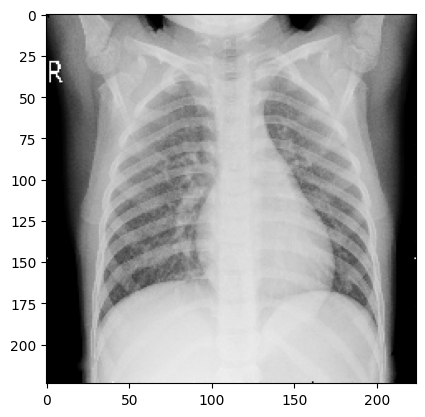

In [32]:
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [33]:
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 2s 2s/step - loss: 0.4101 - accuracy: 0.8125 - precision: 1.0000 - recall: 0.6250
 Testing Acc :  0.8125
 Testing Precision  1.0
 Testing Recall  0.625
